[로지스틱 회귀]

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

In [2]:
cancer=load_breast_cancer()

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
scaler=StandardScaler()
scaled_data=scaler.fit_transform(cancer.data)

In [5]:
x_train,x_test,y_train,y_test=train_test_split(scaled_data,cancer.target,test_size=0.3,random_state=0)

In [6]:
from sklearn.metrics import accuracy_score,roc_auc_score

In [7]:
lr_clf=LogisticRegression()

In [8]:
lr_clf.fit(x_train,y_train)

LogisticRegression()

In [9]:
lr_pred=lr_clf.predict(x_test)
lr_pred_proba=lr_clf.predict_proba(x_test)[:,1]

In [10]:
print('accuracy:{0:.3f},roc_auc:{1:.3f}'.format(accuracy_score(y_test,lr_pred),
                                                roc_auc_score(y_test,lr_pred_proba)))

accuracy:0.977,roc_auc:0.995


In [11]:
solvers=['lbfgs','liblinear','newton-cg','sag','saga']

for solver in solvers:
    lr_clf=LogisticRegression(solver=solver,max_iter=600)
    lr_clf.fit(x_train,y_train)
    lr_pred=lr_clf.predict(x_test)
    lr_pred_proba=lr_clf.predict_proba(x_test)[:,1]

    print('solver: {0}, accuracy: {1:.3f}, roc_auc: {2:.3f}'.format(solver,
                                                                    accuracy_score(y_test,lr_pred),
                                                                    roc_auc_score(y_test,lr_pred_proba)))

solver: lbfgs, accuracy: 0.977, roc_auc: 0.995
solver: liblinear, accuracy: 0.982, roc_auc: 0.995
solver: newton-cg, accuracy: 0.977, roc_auc: 0.995
solver: sag, accuracy: 0.982, roc_auc: 0.995
solver: saga, accuracy: 0.982, roc_auc: 0.995


In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
params={'solver':['liblinear','lbfgs'],
        'penalty':['l2','l1'],
        'C':[0.01,0.1,1,5,10]}

lr_clf=LogisticRegression()

grid_clf=GridSearchCV(lr_clf,param_grid=params,scoring='accuracy',cv=3)
grid_clf.fit(scaled_data,cancer.target)
print('최적 하이퍼 파라미터: {0}, 최적 평균 정확도: {1:.3f}'.format(grid_clf.best_params_,
                                                                grid_clf.best_score_))

최적 하이퍼 파라미터: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도: 0.979


c:\Users\desktop\anaconda3\envs\ML_38\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\desktop\anaconda3\envs\ML_38\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\desktop\anaconda3\envs\ML_38\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\desktop\anaconda3\envs\ML_38\lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver =

[회귀 실습-자전거 대여 수요 예측]

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)

In [15]:
bike_df=pd.read_csv('../data/bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [16]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [17]:
#문자열 -> datetime 타입
bike_df['datetime']=bike_df.datetime.apply(pd.to_datetime)

In [18]:
#datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year']=bike_df.datetime.apply(lambda x:x.year)
bike_df['month']=bike_df.datetime.apply(lambda x:x.month)
bike_df['day']=bike_df.datetime.apply(lambda x:x.day)
bike_df['hour']=bike_df.datetime.apply(lambda x:x.hour)

bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [19]:
drops=['datetime','casual','registered']
bike_df.drop(drops,axis=1,inplace=True)

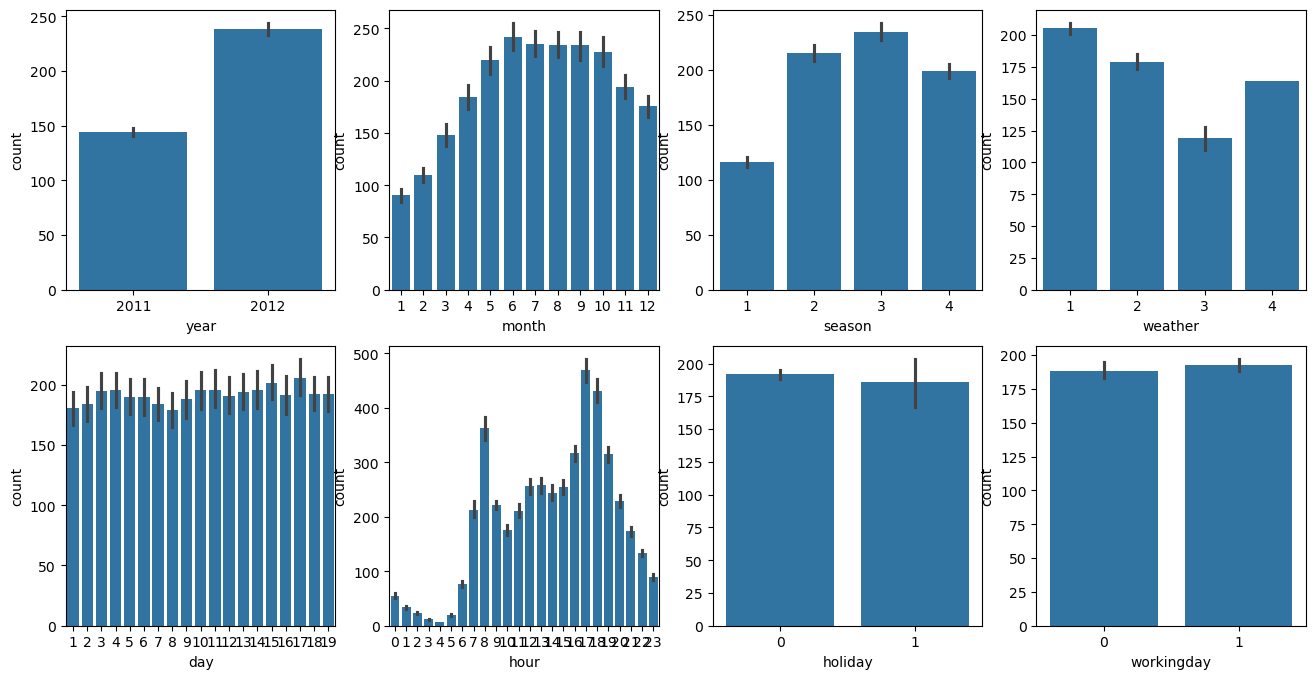

In [21]:
fig,axs=plt.subplots(figsize=(16,8),ncols=4,nrows=2)
cat_feature=['year','month','season','weather','day','hour','holiday','workingday']

for i,feature in enumerate(cat_feature):
    row=int(i/4)
    col=i%4

    sns.barplot(x=feature,y='count',data=bike_df,ax=axs[row][col])

In [22]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [24]:
def rmsle(y,pred):
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)
    squared_error=(log_y-log_pred)**2
    rmsle=np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    rmsle_val=rmsle(y,pred)
    rmse_val=rmse(y,pred)
    mae_val=mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val,rmse_val,mae_val))

In [25]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso

In [26]:
y_target=bike_df['count']
x_feature=bike_df.drop(['count'],axis=1,inplace=False)

In [27]:
x_train,x_test,y_train,y_test=train_test_split(x_feature,y_target,test_size=0.3,random_state=0)

In [28]:
lr_reg=LinearRegression()

In [29]:
lr_reg.fit(x_train,y_train)

LinearRegression()

In [30]:
pred=lr_reg.predict(x_test)

In [31]:
evaluate_regr(y_test,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [36]:
def get_top_error_data(y_test,pred,n_top=5):
    result_df=pd.DataFrame(y_test.values,columns=['real count'])
    result_df['predict count']=np.round(pred)
    result_df['diff']=np.abs(result_df['real count']-result_df['predict count'])

    print(result_df.sort_values('diff',ascending=False)[:n_top])

In [37]:
get_top_error_data(y_test,pred,n_top=5)

      real count  predict count   diff
1618         890          322.0  568.0
3151         798          241.0  557.0
966          884          327.0  557.0
412          745          194.0  551.0
2817         856          310.0  546.0


<Axes: >

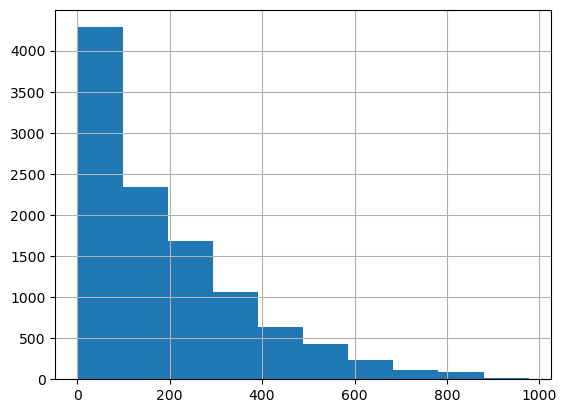

In [38]:
y_target.hist()

<Axes: >

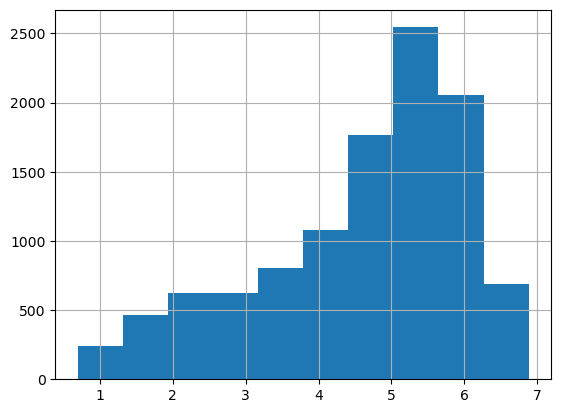

In [39]:
y_log=np.log1p(y_target)
y_log.hist()

In [40]:
y_target_log=np.log1p(y_target)

x_train,x_test,y_train,y_test=train_test_split(x_feature,y_target_log,test_size=0.3,random_state=0)

In [41]:
lr_reg=LinearRegression()

In [42]:
lr_reg.fit(x_train,y_train)

LinearRegression()

In [43]:
pred=lr_reg.predict(x_test)

In [44]:
y_test_exp=np.expm1(y_test)

In [45]:
pred_exp=np.expm1(pred)

In [46]:
evaluate_regr(y_test_exp,pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


<Axes: ylabel='None'>

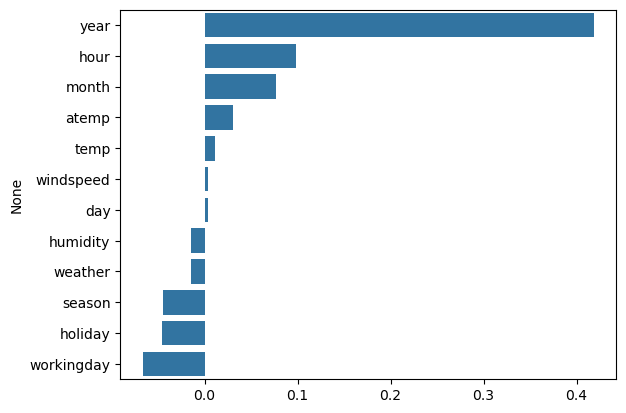

In [47]:
coef=pd.Series(lr_reg.coef_,index=x_feature.columns)
coef_sort=coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values,y=coef_sort.index)

In [49]:
x_feature_ohe=pd.get_dummies(x_feature,columns=['year','month','day','hour','holiday',
                                                'workingday','season','weather'])

In [50]:
x_train,x_test,y_train,y_test=train_test_split(x_feature_ohe,y_target_log,
                                                test_size=0.3,random_state=0)

In [52]:
def get_model_prediction(model,x_train,x_test,y_train,y_test,is_exmp1=False):
    model.fit(x_train,y_train)
    pred=model.predict(x_test)
    if is_exmp1:
        y_test=np.expm1(y_test)
        pred=np.expm1(pred)
    
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test,pred)

In [54]:
lr_reg=LinearRegression()
ridge_reg=Ridge(alpha=10)
lasso_reg=Lasso(alpha=0.01)

for model in [lr_reg,ridge_reg,lasso_reg]:
    get_model_prediction(model,x_train,x_test,y_train,y_test,is_exmp1=True)
    print()

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.690, MAE: 63.383

### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893

### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803



<Axes: ylabel='None'>

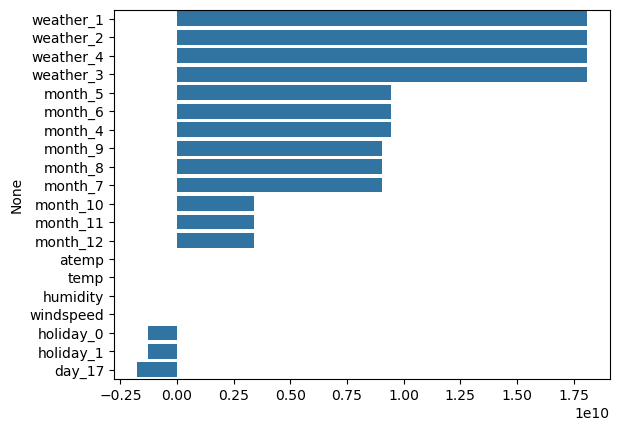

In [56]:
coef=pd.Series(lr_reg.coef_,index=x_feature_ohe.columns)
coef_sort=coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values,y=coef_sort.index)